# Тестовое задание

В данном задании необходимо написать код, который считает следующие признаки для каждого клиента `user_id`:

1. `events_ordinal_number` - порядковый номер события
2. `second_event_time` - время второго события
2.	`loan_ordinal_number` - порядковый номер займа
2.	`events_time_diff` - разница во времени между событиями
2.	`previous_loans_max_amount` - максимальная сумма предыдущего займа.


### Подготовка датафрейма

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import seaborn as sns

In [2]:
size = 10000

df = pd.DataFrame(
    {
        'time': [*pd.date_range('2001-01-01', '2020-09-01', freq='1h')][:size],
        'user_id': np.random.choice(1000, size),
        'type': np.random.choice(2, size, p=[0.8, 0.2]),
        'amount': [int(x//1) for x in  np.random.normal(15_000, 1_000, size)],
        'target': np.random.choice(2, size, p=[0.5, 0.5]),
    },
    index=[*range(size)],
)

In [3]:
df['is_loan'] = df['type']
df['type'] = df['type'].replace({0: 'loanRequest', 1: 'loan'})
df.to_csv('test_origin.csv', index=False)

### Часть 2.1

In [8]:
df_part2=pd.read_csv('test_Feb22.csv').drop('Unnamed: 0', axis=1)
#df_part2['type'] = df_part2['type'].replace({'loanRequest':0, 'loan':1})
df_part2['second_event_time'] =  pd.to_datetime(df_part2['second_event_time'], format='%Y-%m-%d %H:%M:%S')
df_part2=df_part2.drop(['time','user_id','type','second_event_time','events_time_diff'],axis=1)
df_part2['amount']=df_part2['amount']// 1000
df_part2['previous_loans_max_amount']=df_part2['previous_loans_max_amount']// 1000 
df_part2=df_part2.replace(np.nan, 0)
#df_part2

<AxesSubplot:>

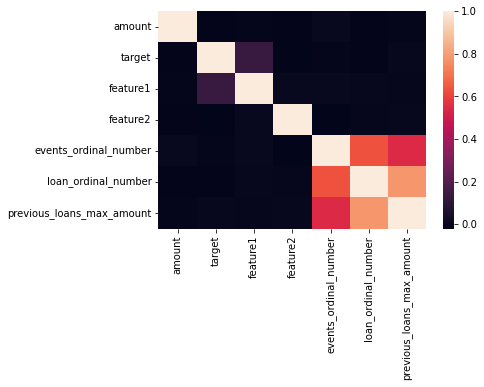

In [9]:
# Предварительно по матрице корреляции заметно влияние feature 1 на target
sns.heatmap(df_part2.corr())

In [30]:
df_part2.corr()

,amount,target,feature1,feature2,events_ordinal_number,loan_ordinal_number,previous_loans_max_amount
amount,1.000000,-0.012596,-0.007686,-0.011972,0.002149,-0.013192,-0.010681
target,-0.012596,1.000000,0.134085,-0.019589,-0.008460,-0.014859,0.000096
feature1,-0.007686,0.134085,1.000000,0.003266,0.001760,-0.003346,-0.003716
feature2,-0.011972,-0.019589,0.003266,1.000000,-0.018513,-0.006232,-0.002643
events_ordinal_number,0.002149,-0.008460,0.001760,-0.018513,1.000000,0.632478,0.540360
loan_ordinal_number,-0.013192,-0.014859,-0.003346,-0.006232,0.632478,1.000000,0.777731
previous_loans_max_amount,-0.010681,0.000096,-0.003716,-0.002643,0.540360,0.777731,1.000000


In [32]:
X=df_part2.drop(['target'], axis=1)
y=df_part2['target']
model = DecisionTreeClassifier(random_state=22,
                               criterion='entropy',
                               splitter='best',
                               min_samples_split=20,
                               min_samples_leaf=10,
                               class_weight='balanced',
                              )
model.fit(X, y)
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop = True)

,feature,importance
0,events_ordinal_number,0.312201
1,feature1,0.190017
2,amount,0.184503
3,loan_ordinal_number,0.157134
4,previous_loans_max_amount,0.151400
5,feature2,0.004745


In [33]:
X=df_part2.drop(['target','events_ordinal_number'], axis=1)
y=df_part2['target']
model = DecisionTreeClassifier(random_state=22,
                               criterion='entropy',
                               splitter='best',
                               min_samples_split=20,
                               min_samples_leaf=10,
                               class_weight='balanced',
                              )
model.fit(X, y)
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop = True)

,feature,importance
0,feature1,0.399861
1,previous_loans_max_amount,0.197575
2,amount,0.193021
3,loan_ordinal_number,0.171700
4,feature2,0.037844


In [34]:
X=df_part2.drop(['target','events_ordinal_number','feature1'], axis=1)
y=df_part2['target']
model = DecisionTreeClassifier(random_state=22,
                               criterion='entropy',
                               splitter='best',
                               min_samples_split=20,
                               min_samples_leaf=10,
                               class_weight='balanced',
                              )
model.fit(X, y)
pd.DataFrame({'feature': X.columns,
              'importance': model.feature_importances_}).sort_values('importance', ascending=False).reset_index(drop = True)

,feature,importance
0,previous_loans_max_amount,0.376196
1,amount,0.306768
2,loan_ordinal_number,0.275975
3,feature2,0.041062


In [ ]:
На основе анализа заметно что вне зависисмости от состава списка параметров значимость переменной feature2 практически не изменяется и остается минимальной, 
тогда как feeature1 изначально показала зависимость на корреляции и далее подтвердила ее при проверке через feature_importances_

### Расчет признаков

#### Признак `events_ordinal_number`

In [17]:
# весь код расчета признака должен быть в этом методе
def calculate_events_number(df):
    events_on=[0] * df.shape[0]#df2
    for i in df['user_id'].unique():
        df_t2=df.loc[df['user_id'] == i]
        ind=df_t2.index
        on=1
        for j in ind:
            events_on[j]=on
            on+=1
    df['events_ordinal_number'] = events_on#тут ваш код
    
    return df

#### Признак `second_event_time`

In [18]:
# весь код расчета признака должен быть в этом методе
def calculate_second_event_time(df):
    second_et=[0] * df.shape[0]#df2
    for i in df['user_id'].unique():
        df_t2=df.loc[df['user_id'] == i]
        ind=df_t2.index
        if len(ind)<2:
            second_et[ind[0]]=np.nan
        else:
            se_et=df_t2['time'][ind[1]]
            for j in ind:
                second_et[j]=se_et
    df['second_event_time'] = second_et#тут ваш код
    return df

#### Признак `loan_ordinal_number`

In [19]:
# весь код расчета признака должен быть в этом методе
def calculate_loan_number(df):
    loan_on=[0] * df.shape[0]#df2
    for i in df['user_id'].unique():
        df_t=df.loc[df['user_id'] == i]
        ind=df_t.index
        cr_cnt=1
        for j in ind:
            if df_t['type'][j] == 'loan':
                loan_on[j]=cr_cnt
                cr_cnt+=1
            else: 
                loan_on[j]=cr_cnt
    df['loan_ordinal_number'] =loan_on #тут ваш код

    return df

#### Признак `events_time_diff`

In [20]:
# весь код расчета признака должен быть в этом методе
def calculate_time_diff(df):
    calc_td=[0] * df.shape[0]#df2
    for i in df['user_id'].unique():
        df_t=df.loc[df['user_id'] == i]
        a=df_t['time'].diff()
        ind=df_t.index
        for j in ind:
            calc_td[j]=a[j]
    df['events_time_diff'] =calc_td #тут ваш код

    return df

#### Признак `previous_loans_max_amount`

In [21]:
# весь код расчета признака должен быть в этом методе
def calculate_previous_max_amount(df):    
    pmax=[np.nan] * df.shape[0]#df2
    for i in df['user_id'].unique():
        df_t=df.loc[df['user_id'] == i]
        ind=df_t.index
        mx=[]
        for j in ind:
            if df_t['type'][j] == 'loan' and len(mx)>0:
                pmax[j]=max(mx)
                mx.append(df_t['amount'][j])
            elif df_t['type'][j] == 'loan' and len(mx)==0:
                mx.append(df_t['amount'][j])
            elif len(mx)>0:
                pmax[j]=max(mx)
                
    df['previous_loans_max_amount'] = pmax #тут ваш код

    return df

### Сохранение итогового датасета с признаками

Этот код трогать не нужно.

In [28]:
def calculate_feature(df):
    calculate_events_number(df)# отдельно скорость  180 ms ± 11.5 ms per loop
    calculate_second_event_time(df)# отдельно скорость 248 ms ± 11.5 ms per loop
    calculate_loan_number(df)# отдельно скорость 281 ms ± 32.1 ms per loop
    calculate_time_diff(df)# отдельно скорость 1.17 s ± 33.4 ms per 
    calculate_previous_max_amount(df)# отдельно скорость 1.04 s ± 52 ms per loop 

In [29]:
%%timeit -o 
calculate_feature(df)

4.75 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 4.75 s ± 106 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [ ]:
columns = ['time']
rez = _
df_time = pd.DataFrame([rez], None, columns)
df_time.to_csv('time.csv', index=False)

In [ ]:
df.to_csv('test.csv', index=False)